In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timezone
import matplotlib.lines as mlines


In [2]:
# set directories and files

datadir=r"C:\\Users\\dswanson\\Documents\\Files\\Satellites\\LLITED\\06 data\\"
ephdir=datadir+r'ephemeris\\Ephemeris_simple\\'
savedir=r"C:\\Users\\dswanson\\Documents\\Files\\Satellites\\LLITED\\05 analysis\\gannon day storm\\plots\\"

pipdatadir = datadir+'\\PIP\\L2\\'
migsidatadir = datadir+'\\MIGSI\\L2\\'

pipfiles=[pipdatadir+'LLITED_B_PIP_20240507_L2_v4.nc4',\
          pipdatadir+'LLITED_B_PIP_20240508_L2_v4.nc4',\
          pipdatadir+'LLITED_B_PIP_20240510_L2_v4.nc4',\
          pipdatadir+'LLITED_B_PIP_20240511_L2_v4.nc4',\
          pipdatadir+'LLITED_B_PIP_20240512_L2_v4.nc4',\
          pipdatadir+'LLITED_B_PIP_20240513_L2_v4.nc4']

migsifiles=[migsidatadir+'LLITEDB_MIGSI_20240507_033038_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240508_094038_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240510_094038_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240511_050238_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240512_094038_L2_v01.nc',\
            migsidatadir+'LLITEDB_MIGSI_20240513_050138_L2_v01.nc']


In [3]:
# LLITED data near PFISR
may_nden = [None]*len(migsifiles)
may_alt = [None]*len(migsifiles)
may_ni = [None]*len(migsifiles)
# LLITED data near polar cap (pc) location near risr
may_nden_pc = [None]*len(migsifiles)
may_alt_pc = [None]*len(migsifiles)
may_ni_pc = [None]*len(migsifiles)

for j in (2,4):
    pipfile=pipfiles[j]
    migsifile=migsifiles[j]
    date1 = pipfile.split('_')[3]
    print(date1)
    
    #Load the NetCDF file into a new xarray dataset
    pip = xr.open_dataset(pipfile)
    pip_s1970=pip['time'].values.astype('int64')*1e-9
    migsi = xr.open_dataset(migsifile)
    eph_data = xr.open_dataset(ephdir+'LLITEDB_202405.nc')

    # base everything on MIGSI start and stop
    eph = eph_data.where((eph_data['UNIX_EPOCH'] > migsi['s1970'][0]) &(eph_data['UNIX_EPOCH'] < migsi['s1970'][-1]),drop=True)
   
    wp = np.where((pip_s1970 > migsi['s1970'][0].values) & (pip_s1970< migsi['s1970'][-1].values ) )
    w1=np.where(migsi['nden'] > -1)

    # Now that everything has the same start and stop times interpolate data to all be on ephemeris time resolution
    pip_ni=np.interp(eph['UNIX_EPOCH'],pip_s1970[wp],pip['Ni'][wp])
    migsi_nden=np.interp(eph['UNIX_EPOCH'],migsi['s1970'],migsi['nden'])
    w1= np.where(migsi['nden'] >-1)
    migsi_nden=np.interp(eph['UNIX_EPOCH'],migsi['s1970'][w1],migsi['nden'][w1])
    
    # PFISR is located at 65.12992 N, 147.47104W
    ww= np.where((eph['LAT (deg)'] < 66.26) & (eph['LAT (deg)'] >66.0) & (eph['LON (deg)'] <-100))[0]
    ww_pc= np.where((eph['LAT (deg)'] < 83.4) & (eph['LAT (deg)'] >79) & (eph['LON (deg)'] <-80))[0]

    # average the 2 mins of data
    _nden=np.mean(migsi['nden'][w1].values)
    _ni=(np.mean(pip_ni))
    _alt=np.mean(migsi['alt'][w1].values)
    # could take middle point here
    #_ni=pip_ni[ww[len(ww)//2]]
    #_alt=(eph['ALT (km)'][ww[len(ww)//2]])
    #_nden=(migsi_nden[ww[len(ww)//2]])
   
    may_nden[j] = _nden
    may_ni[j] = _ni
    may_alt[j] = _alt

    _ni_pc=pip_ni[ww_pc[len(ww_pc)//2]]
    _alt_pc=(eph['ALT (km)'][ww_pc[len(ww_pc)//2]])
    _nden_pc=(migsi_nden[ww_pc[len(ww_pc)//2]])
   
    may_nden_pc[j] = _nden_pc
    may_ni_pc[j] = _ni_pc
    may_alt_pc[j] = _alt_pc

    # check taking locations and times expect
    # mid points
    #print('LON',(eph['LON (deg)'][ww[len(ww)//2]].values))
    #print('LAT',(eph['LAT (deg)'][ww[len(ww)//2]].values))
    #print('ALT',(eph['ALT (km)'][ww[len(ww)//2]]).values) 
    #print('UNIX_EPOCH',(eph['UNIX_EPOCH'][ww[len(ww)//2]].values))
    #print(datetime.fromtimestamp(float(eph['UNIX_EPOCH'][ww[len(ww)//2]].values),tz=timezone.utc))

    #print('LON',(eph['LON (deg)'][ww[0]].values))
    #print('LAT',(eph['LAT (deg)'][ww[0]].values))
    #print('ALT',(eph['ALT (km)'][ww[0]]).values)
    #print('UNIX_EPOCH',(eph['UNIX_EPOCH'][ww[0]].values))
    #print(datetime.fromtimestamp(float(eph['UNIX_EPOCH'][ww[0]].values),tz=timezone.utc))
    #print('LON',(eph['LON (deg)'][ww[-1]].values))
    #print('LAT',(eph['LAT (deg)'][ww[-1]].values))
    #print('ALT',(eph['ALT (km)'][ww[-1]]).values) 
    #print('UNIX_EPOCH',(eph['UNIX_EPOCH'][ww[-1]].values))
    #print(datetime.fromtimestamp(float(eph['UNIX_EPOCH'][ww[-1]].values),tz=timezone.utc))
    

    
    #print('pc LON',(eph['LON (deg)'][ww_pc[len(ww_pc)//2]].values))
    #print('pc LAT',(eph['LAT (deg)'][ww_pc[len(ww_pc)//2]].values))
    #print('pc ALT',(eph['ALT (km)'][ww_pc[len(ww_pc)//2]].values)) 
    #print('pc UNIX_EPOCH',(eph['UNIX_EPOCH'][ww_pc[len(ww_pc)//2]].values))
    #print('pc ',datetime.fromtimestamp(float(eph['UNIX_EPOCH'][ww_pc[len(ww_pc)//2]].values),tz=timezone.utc))

    
    
    #print('pc LON',(eph['LON (deg)'][ww_pc[0]].values))
    #print('pc LAT',(eph['LAT (deg)'][ww_pc[0]].values))
    #print('pc ALT',(eph['ALT (km)'][ww_pc[0]]).values) 
    #print('pc UNIX_EPOCH',(eph['UNIX_EPOCH'][0].values))
    #print('pc ',datetime.fromtimestamp(float(eph['UNIX_EPOCH'][ww_pc[0]].values),tz=timezone.utc))
   
    #print('pc LON',(eph['LON (deg)'][ww_pc[-1]].values))
    #print('pc LAT',(eph['LAT (deg)'][ww_pc[-1]].values))
    #print('pc ALT',(eph['ALT (km)'][ww_pc[-1]]).values) 
    #print('pc UNIX_EPOCH',(eph['UNIX_EPOCH'][ww_pc[-1]]).values)
    #print('pc ',datetime.fromtimestamp(float(eph['UNIX_EPOCH'][ww_pc[-1]].values),tz=timezone.utc))
    

20240510
20240512


In [4]:
# Get TIE-GCM Profile data
tiedir='C:\\Users\\dswanson\Documents\\Files\\Satellites\\LLITED\\06 data\\TIEGCM\\May_2024_Storm\\'

# TIE-GCM profile files near -147.5 Lon near PFISR
file_NH1='TIE_GCM_may10_1000_heelis_fanjiang_height.txt'
file_NH2='TIE_GCM_may11_1000_heelis_fanjiang_height.txt'
file_NH3='TIE_GCM_may12_1000_heelis_fanjiang_height.txt'

# TIE-GCM profile files near -95 lon near RISR-N
# pc for polar cap
file_NH1_pc='TIE_GCM_may10_1000_heelis_fanjiang_height_risr.txt'
file_NH2_pc='TIE_GCM_may11_1000_heelis_fanjiang_height_risr.txt'
file_NH3_pc='TIE_GCM_may12_1000_heelis_fanjiang_height_risr.txt'


head_height=['Lon', 'Lat','H','T_n','Vn_Lon','Vn_Lat','WN','rho(O2)','rho(O)','N2','rho(NO)','rho(N4S)','HE','N_e','T_e','T_i','TEC','N(O2+)',\
      'N(O+)','PHI','Vi_Lon','Vi_Lat','Vi_IP','DEN', 'QJOULE','HMF2', 'NMF2','Z','ZG','SIGMA_PED','SIGMA_HAL','NO_COOL','QJOULE_INTEG',\
      'O_N2','T_lbc','Vlbc_Lon','Vlbc_Lat','TN_lbc','VN_lbc_Lon','VN_lbc_Lat']

tiehNH1 = pd.read_csv(tiedir+file_NH1, encoding='ascii',names=head_height,sep='\s+',comment='#')
tiehNH2 = pd.read_csv(tiedir+file_NH2, encoding='ascii',names=head_height,sep='\s+',comment='#')
tiehNH3 = pd.read_csv(tiedir+file_NH3, encoding='ascii',names=head_height,sep='\s+',comment='#')

tiehNH1_pc = pd.read_csv(tiedir+file_NH1_pc, encoding='ascii',names=head_height,sep='\s+',comment='#')
tiehNH2_pc = pd.read_csv(tiedir+file_NH2_pc, encoding='ascii',names=head_height,sep='\s+',comment='#')
tiehNH3_pc = pd.read_csv(tiedir+file_NH3_pc, encoding='ascii',names=head_height,sep='\s+',comment='#')



#display(tiehNH1_pc)


In [5]:
# index where TIE-GCM profiles are between 64-67 LAT
# These files are already constrained to -147.5 Lon near PFISR

wNH1=np.where((tiehNH1['Lat'] >64) & (tiehNH1['Lat'] <67))[0]# 
wNH2=np.where((tiehNH2['Lat'] >64) & (tiehNH2['Lat'] <67))[0]# 
wNH3=np.where((tiehNH3['Lat'] >64) & (tiehNH3['Lat'] <67))[0]# 

# index where TIE-GCM profiles are between 74-77 LAT
# These files are already constrained to -95 Lon near RISR

wNH1_pc=np.where((tiehNH1_pc['Lat'] >74) & (tiehNH1['Lat'] <77))[0]# 
wNH2_pc=np.where((tiehNH2_pc['Lat'] >74) & (tiehNH2['Lat'] <77))[0]# 
wNH3_pc=np.where((tiehNH3_pc['Lat'] >74) & (tiehNH3['Lat'] <77))[0]# 



In [6]:
# Get PFISR data
pfisrdir=r"C:\\Users\\dswanson\\Documents\\Files\\Satellites\\LLITED\\05 analysis\\PFISR\\"

# RISR File
risr_lp = pfisrdir+'/RISR/20240510.002_lp_1min-fitcal.h5'

#PFISR Files
# ac files from LLITED campaign
filename_ac=[pfisrdir+'20240507.001_ac_1min-fitcal.h5',
             pfisrdir+'20240508.002_ac_1min-fitcal.h5',
             pfisrdir+'20240510.002_ac_1min-fitcal.h5',
             pfisrdir+'20240511.002_ac_1min-fitcal.h5',
             pfisrdir+'20240512.003_ac_1min-fitcal.h5',
             pfisrdir+'20240513.003_ac_1min-fitcal.h5' 
            ]

# lp files from LLITED campaign
filename_lp=[pfisrdir+'20240507.001_lp_1min-fitcal.h5',
             pfisrdir+'20240508.002_lp_1min-fitcal.h5',
             pfisrdir+'20240510.002_lp_1min-fitcal.h5',
             pfisrdir+'20240511.002_lp_1min-fitcal.h5',
             pfisrdir+'20240512.003_lp_1min-fitcal.h5',
             pfisrdir+'20240513.003_lp_1min-fitcal.h5',
            ]


In [7]:
# for each PFISR file read the files, save an average value, # can uncomment and plot PFISR data
n_days = len(filename_lp)
pfisr_mean_ac=[[None]]*n_days
pfisr_mean_lp=[[None]]*n_days
alt_ac_p=[[None]]*n_days
alt_lp_p=[[None]]*n_days
pfisr_error_lp=[[None]]*n_days  


#fig, axes = plt.subplots(n_days, 1, figsize=(7,12), sharex=False)
for i in range(n_days):
    # LP file
    with h5py.File(filename_lp[i], 'r') as h5:
        beamcodes = h5['BeamCodes'][:]
        bidx = np.argmax(beamcodes[:,2])
        alt_lp = h5['FittedParams/Altitude'][bidx,:]
        ne_lp = h5['FittedParams/Ne'][:,bidx,:]
        utime_lp = h5['Time/UnixTime'][:,0]
        # Read in error array
        dNe = h5['FittedParams/dNe'][:]
    time_lp = utime_lp.astype('datetime64[s]')

    # AC file
    with h5py.File(filename_ac[i], 'r') as h5:
        beamcodes = h5['BeamCodes'][:]
        bidx = np.argmax(beamcodes[:,2])
        alt_ac = h5['FittedParams/Altitude'][bidx,:]
        ne_ac = h5['FittedParams/Ne'][:,bidx,:]
        utime_ac = h5['Time/UnixTime'][:,0]
    time_ac = utime_ac.astype('datetime64[s]')

    cutoff_alt = 150.*1000.
    aidx_ac = np.argmin(np.abs(alt_ac-cutoff_alt))
    aidx_lp = np.argmin(np.abs(alt_lp-cutoff_alt))

    #ax = axes[i]
    #c = ax.pcolormesh(time_ac, alt_ac[:aidx_ac]/1000,
    #                  ne_ac[:,:aidx_ac].T*1e-6,
    #                  vmin=0., vmax=4.e5, cmap='jet')
    #c = ax.pcolormesh(time_lp, alt_lp[aidx_lp:]/1000,
    #                  ne_lp[:,aidx_lp:].T*1e-6,
    #                  vmin=0., vmax=4.e5, cmap='jet')
    #ax.plot(time_lp[64],425,'o',color='magenta',markersize=10)
    ## Title in YYYYMMDD format
    #date_str = str(time_lp[0])[:10].replace('-', '')
    #ax.set_title(f'{date_str}')
    #ax.set_ylabel('Altitude (km)')
    #ax.set_xlabel('Universal Time (HH:MM)')

    ## Format x-axis
    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    ## Force time range for plot 08:345–10:45
    #day = np.datetime64(str(time_lp[0])[:10])
    #start = day + np.timedelta64(8*60+45, 'm')   # 08:45
    #end   = day + np.timedelta64(10*60+45, 'm')  # 10:45
    #ax.set_xlim(start, end)

    # take mean +/-30 mins of 10:00UT
    #print('time 1',time_lp[38])
    #print('time 2',time_lp[90])

    pfisr_mean_ac[i] = np.nanmean(ne_ac[38:90,:aidx_ac],axis=0)
    pfisr_mean_lp[i] = np.nanmean(ne_lp[38:90,aidx_lp:],axis=0)
    n_valid = np.sum(~np.isnan(ne_lp[38:90,aidx_lp:]), axis=0)
    pfisr_error_lp[i] = np.sqrt(np.nansum(dNe[38:90,bidx,aidx_lp:]**2, axis=0)) / n_valid

    alt_ac_p[i]=alt_lp[:aidx_ac]/1000
    alt_lp_p[i]=alt_lp[aidx_lp:]/1000


## Adjust layout and add smaller colorbar
#fig.tight_layout(rect=[0,0,0.92,1])
#cbar = fig.colorbar(c, ax=axes.ravel().tolist(), label=r'Plasma Density (cm$^{-3}$)', shrink=0.5, pad=0.05)

## Force scientific notation on colorbar labels
#cbar.formatter = ScalarFormatter(useMathText=True)
#cbar.formatter.set_scientific(True)
#cbar.formatter.set_powerlimits((-2, 2))  # adjust range for scientific notation
##cbar.update_ticks()#
#fig.suptitle('PFISR Plasma Density'+'\n Beam : {:.0f} (az:{:.1f}, el:{:.1f})'.format(beamcodes[bidx,0], beamcodes[bidx,1], beamcodes[bidx,2]),fontsize=12,x=0.42)

#plt.savefig(savedir+'PFISRelectron_multiday_jet.png', bbox_inches='tight')
#plt.show()


In [8]:
# for each RISN_N file read the files, save an average value, # can uncomment and plot RISR-N data

risr_mean_lp=[[None]]*2
risr_alt_lp=[[None]]*2
risr_error_lp=[[None]]*n_days  

risr_filename_lp = [pfisrdir+'/RISR/20240510.002_lp_1min-fitcal.h5']

#fig, axes = plt.subplots(2, 1, figsize=(7,4.8), sharex=False)
#fig.suptitle('RISR-N Plasma Density'+'\n Beam : {:.0f} (az:{:.1f}, el:{:.1f})'.format(beamcodes[bidx,0], beamcodes[bidx,1], beamcodes[bidx,2]),fontsize=12,x=0.41)

for i in range(len(risr_filename_lp)):
    with h5py.File(risr_filename_lp[i], 'r') as h5:
        beamcodes = h5['BeamCodes'][:]
        bidx = np.argmax(beamcodes[:,2])
        alt_lp = h5['FittedParams/Altitude'][bidx,:]
        ne_lp = h5['FittedParams/Ne'][:,bidx,:]
        utime_lp = h5['Time/UnixTime'][:,0]
        dNe = h5['FittedParams/dNe'][:]

    time_lp = utime_lp.astype('datetime64[s]')

 
#ax = axes[0]
mask = np.isfinite(alt_lp)

#c = ax.pcolormesh(time_lp, alt_lp[mask]/1000,ne_lp[:,mask].T*1e-6,
#                      vmin=0, vmax=4e5, cmap='jet')

#day = np.datetime64('2024-05-11') #np.datetime64(str(time_lp[0])[:10])
#start = day + np.timedelta64(8*60+45, 'm')   # 08:45
#end   = day + np.timedelta64(10*60+45, 'm')  # 10:45
#ax.set_xlim(start, end)

## take mean +/-30 mins of 10:00UT
#print('time 1',time_lp[915])
##print('time 2',time_lp[935])

risr_mean_lp[0] = np.nanmean(ne_lp[896:915,mask],axis=0)
risr_alt_lp[0]=alt_lp[mask]/1000

#σ_mean = sqrt(Σ(σᵢ²)) / N because taking the mean
n_valid = np.sum(~np.isnan(ne_lp[896:915,mask]), axis=0)
risr_error_lp[0] = np.sqrt(np.nansum(dNe[896:915,bidx,mask]**2, axis=0)) / n_valid
 
    
#date_str = str(day).replace('-', '')
#ax.set_title(f'{date_str}')
#ax.set_xlabel('Universal Time (HH:MM)')
#ax.set_ylabel('Altitude (km)')
 
## Format x-axis as HH:MM
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
#ax = axes[1]
#mask = np.isfinite(alt_lp)
#c = ax.pcolormesh(time_lp, alt_lp[mask]/1000,ne_lp[:,mask].T*1e-6,
#                  vmin=0, vmax=4e5, cmap='jet')
## take mean +/-30 mins of 10:00UT
#print('time 1',time_lp[2264])
#print('time 2',time_lp[2283])

risr_mean_lp[1] = np.nanmean(ne_lp[2264:2283,mask],axis=0)
risr_alt_lp[1]=alt_lp[mask]/1000

#σ_mean = sqrt(Σ(σᵢ²)) / N because taking the mean
n_valid = np.sum(~np.isnan(ne_lp[2264:2283,mask]), axis=0)
risr_error_lp[1] = np.sqrt(np.nansum(dNe[2264:2283,bidx,mask]**2, axis=0)) / n_valid
 
#day = np.datetime64('2024-05-12') #np.datetime64(str(time_lp[0])[:10])
#start = day + np.timedelta64(8*60+45, 'm')   # 08:45
#end   = day + np.timedelta64(10*60+45, 'm')  # 10:45
#ax.set_xlim(start, end)
    
#date_str = str(day).replace('-', '')
#ax.set_title(f'{date_str}')
#ax.set_xlabel('Universal Time (HH:MM)')
#ax.set_ylabel('Altitude (km)')

## Format x-axis as HH:MM
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    
#fig.tight_layout(rect=[0,0,0.92,1])
#cbar = fig.colorbar(c, ax=axes.ravel().tolist(), label=r'Plasma Density (cm$^{-3}$)', shrink=0.7, pad=0.06)

# Force scientific notation on colorbar labels
#cbar.formatter = ScalarFormatter(useMathText=True)
#cbar.formatter.set_scientific(True)
#cbar.formatter.set_powerlimits((-2, 2))  # adjust range for scientific notation
#cbar.update_ticks()#
#plt.show()

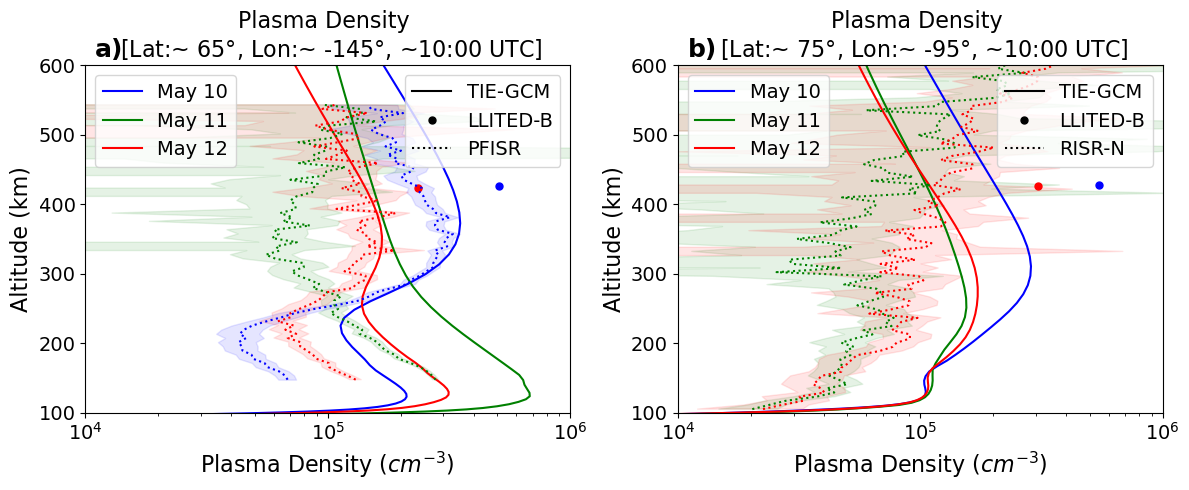

In [9]:
# Create figure with PFISR and RISR-N profiles with TIE-GCM and LLITED
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Define common color and style dictionaries
date_colors = {
    'May 10': 'b',
    'May 11': 'g',
    'May 12': 'r',
}

# ========== LEFT SUBPLOT (PFISR) ==========
type_styles_left = {
    'TIE-GCM': dict(linestyle='-', marker=None),
    'LLITED-B': dict(linestyle='None', marker='.', markersize=10),
    'PFISR': dict(linestyle='dotted', marker=None)
}

# Plot data 
ax1.plot(tiehNH1['N_e'][wNH1], tiehNH1['H'][wNH1], color=date_colors['May 10'], **type_styles_left['TIE-GCM'])
ax1.plot(tiehNH2['N_e'][wNH2], tiehNH2['H'][wNH2], color=date_colors['May 11'], **type_styles_left['TIE-GCM'])
ax1.plot(tiehNH3['N_e'][wNH3], tiehNH3['H'][wNH3], color=date_colors['May 12'], **type_styles_left['TIE-GCM'])
ax1.plot(may_ni[2]*1e-6, may_alt[2], color=date_colors['May 10'], **type_styles_left['LLITED-B'])
ax1.plot(may_ni[4]*1e-6, may_alt[4], color=date_colors['May 12'], **type_styles_left['LLITED-B'])

# PFISR data with error bars
ax1.plot(pfisr_mean_lp[2]*1e-6, alt_lp_p[2], color=date_colors['May 10'], **type_styles_left['PFISR'])
ax1.fill_betweenx(alt_lp_p[2], 
                  (pfisr_mean_lp[2] - pfisr_error_lp[2])*1e-6,
                  (pfisr_mean_lp[2] + pfisr_error_lp[2])*1e-6,
                  color=date_colors['May 10'], alpha=0.1)

ax1.plot(pfisr_mean_lp[3]*1e-6, alt_lp_p[3], color=date_colors['May 11'], **type_styles_left['PFISR'])
ax1.fill_betweenx(alt_lp_p[3], 
                  (pfisr_mean_lp[3] - pfisr_error_lp[3])*1e-6,
                  (pfisr_mean_lp[3] + pfisr_error_lp[3])*1e-6,
                  color=date_colors['May 11'], alpha=0.1)

ax1.plot(pfisr_mean_lp[4]*1e-6, alt_lp_p[4], color=date_colors['May 12'], **type_styles_left['PFISR'])
ax1.fill_betweenx(alt_lp_p[4], 
                  (pfisr_mean_lp[4] - pfisr_error_lp[4])*1e-6,
                  (pfisr_mean_lp[4] + pfisr_error_lp[4])*1e-6,
                  color=date_colors['May 12'], alpha=0.1)


ax1.set_ylabel('Altitude (km)', fontsize=16)
ax1.set_xlabel('Plasma Density ($cm^{-3}$)', fontsize=16)
ax1.set_ylim([100, 600])
ax1.set_xlim([1e4, 1e6])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xscale('log')
ax1.set_title('Plasma Density \n [Lat:~ 65$\degree$, Lon:~ -145$\degree$, ~10:00 UTC]', fontsize=16)


date_handles = [mlines.Line2D([], [], color=c, linestyle='-', label=d) for d, c in date_colors.items()]
type_handles_left = [mlines.Line2D([], [], color='black', **style, label=name) for name, style in type_styles_left.items()]
legend1_left = ax1.legend(handles=date_handles, loc='upper left',fontsize=14)
legend2_left = ax1.legend(handles=type_handles_left, loc='upper right',fontsize=14)
ax1.add_artist(legend1_left)

# SUBPLOT (RISR-N)
type_styles_right = {
    'TIE-GCM': dict(linestyle='-', marker=None),
    'LLITED-B': dict(linestyle='None', marker='.', markersize=10),
    'RISR-N': dict(linestyle='dotted', marker=None),
}

# Plot data
ax2.plot(tiehNH1_pc['N_e'][wNH1_pc], tiehNH1_pc['H'][wNH1_pc], color=date_colors['May 10'], **type_styles_right['TIE-GCM'])
ax2.plot(tiehNH2_pc['N_e'][wNH2_pc], tiehNH2_pc['H'][wNH2_pc], color=date_colors['May 11'], **type_styles_right['TIE-GCM'])
ax2.plot(tiehNH3_pc['N_e'][wNH3_pc], tiehNH3_pc['H'][wNH3_pc], color=date_colors['May 12'], **type_styles_right['TIE-GCM'])
ax2.plot(may_ni_pc[2]*1e-6, may_alt_pc[2], color=date_colors['May 10'], **type_styles_right['LLITED-B'])
ax2.plot(may_ni_pc[4]*1e-6, may_alt_pc[4], color=date_colors['May 12'], **type_styles_right['LLITED-B'])

# RISR-N data with error bars
ax2.plot(risr_mean_lp[0]*1e-6, risr_alt_lp[0], color=date_colors['May 11'], **type_styles_right['RISR-N'])
ax2.fill_betweenx(risr_alt_lp[0],
                  (risr_mean_lp[0] - risr_error_lp[0])*1e-6,
                  (risr_mean_lp[0] + risr_error_lp[0])*1e-6,
                  color=date_colors['May 11'], alpha=0.1)

ax2.plot(risr_mean_lp[1]*1e-6, risr_alt_lp[1], color=date_colors['May 12'], **type_styles_right['RISR-N'])
ax2.fill_betweenx(risr_alt_lp[1], 
                  (risr_mean_lp[1] - risr_error_lp[1])*1e-6,
                  (risr_mean_lp[1] + risr_error_lp[1])*1e-6,
                  color=date_colors['May 12'], alpha=0.1)


ax2.set_ylabel('Altitude (km)', fontsize=16)
ax2.set_xlabel('Plasma Density ($cm^{-3}$)', fontsize=16)
ax2.set_ylim([100, 600])
ax2.set_xlim([1e4, 1e6])
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xscale('log')
ax2.set_title('Plasma Density \n [Lat:~ 75$\degree$, Lon:~ -95$\degree$, ~10:00 UTC]', fontsize=16)

ax1.text(0.02, 1.01, 'a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', va='bottom', ha='left')
ax2.text(0.02, 1.01, 'b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', va='bottom', ha='left')

type_handles_right = [mlines.Line2D([], [], color='black', **style, label=name) for name, style in type_styles_right.items()]
legend1_right = ax2.legend(handles=date_handles, loc='upper left', fontsize=14)
legend2_right = ax2.legend(handles=type_handles_right, loc='upper right', fontsize=14)
ax2.add_artist(legend1_right)


plt.tight_layout()
#plt.savefig(savedir+'TIEGCM\\LLITED_TIEGCM__ISR_profiles_combined.png', facecolor='white', transparent=False, bbox_inches='tight', dpi=300)
plt.show()
